In [12]:
import mailbox
import csv
import pandas as pd
from email.policy import default
import numpy as np

In [13]:
email_file = "C:\\Users\\evan.wimpey\\Box\\Evan Wimpey\\BD-HITEC sales emails.mbox"

In [39]:
mbox = mailbox.mbox(email_file)

# Extract the data
data = []

for message in mbox:
    sender = message['from']
    date = message['date']
    subject = message['subject']
    payload = message.get_payload()
    text_content = ""
    attachments = []
    image_count = 0
    animation_count = 0

    if message.is_multipart():
        for part in message.walk():
            content_type = part.get_content_type()
            if content_type == 'text/plain':
                text_content += part.get_payload(decode=True).decode(part.get_content_charset() or 'utf-8')
            elif content_type.startswith('image/'):
                if content_type == 'image/gif':
                    animation_count += 1
                image_count += 1
                attachments.append(part.get_filename())
            elif content_type.startswith('video/') or content_type == 'application/x-shockwave-flash':
                animation_count += 1
                attachments.append(part.get_filename())
            elif part.get('Content-Disposition') is not None:
                attachments.append(part.get_filename())
    else:
        text_content = message.get_payload(decode=True).decode(message.get_content_charset() or 'utf-8')

    data.append({
        'sender': sender,
        'datetime': date,
        'subject': subject,
        'message': text_content,
        'attachments': attachments,
        'image_count': image_count,
        'animation_count': animation_count
    })

# Create DataFrame
df = pd.DataFrame(data)

# Display DataFrame
df.head()

,sender,datetime,subject,message,attachments,image_count,animation_count
0,"""Anand System Inc."" <sales@anandsystems.com>","Fri, 21 Jun 2024 19:35:13 +0000",Come visit us at HITEC Booth #1041,Hello \r\n\r\n<http://tracking.anandsystems.co...,[],0,0
1,Vincent Oliver <vince@hotelgeofencing.com>,"Thu, 6 Jun 2024 14:41:26 -0400",Beyond OTAs: Explore Geofencing & Streaming TV...,Learn how to pair geofencing and streaming TV ...,[],0,0
2,Bodhi <info@bodhi.software>,"Tue, 25 Jun 2024 08:30:44 -0400 (EDT)",You are invited to a happy hour at the Bodhi b...,Join us at our Happy Hour in Booth #226 I’d ...,[],0,0
3,=?UTF-8?B?ZGFpbHlwb2ludOKEog==?= <BigDataHotel...,"Wed, 26 Jun 2024 13:43:27 +0200",=?UTF-8?Q?=F0=9F=91=80_Discover_Why_dailypoint...,Unleashing #HospitalityTechInnovations Dif...,[],0,0
4,"""Jeff Kessinger"" <jeff.kessinger@jonaschorum.com>","Wed, 12 Jun 2024 11:04:11 -0500",How guest data is the key to increasing revenue,Te secret to boosting revenue is at your finge...,[],0,0


In [40]:
df.shape

(126, 7)

In [15]:
np.mean(df['animation_count']>0)

0.023809523809523808

In [16]:
# Counting how many rows have any attachments
attachment_count = df[df['attachments'].apply(len) > 0].shape[0]
print(attachment_count/len(df))


0.1111111111111111


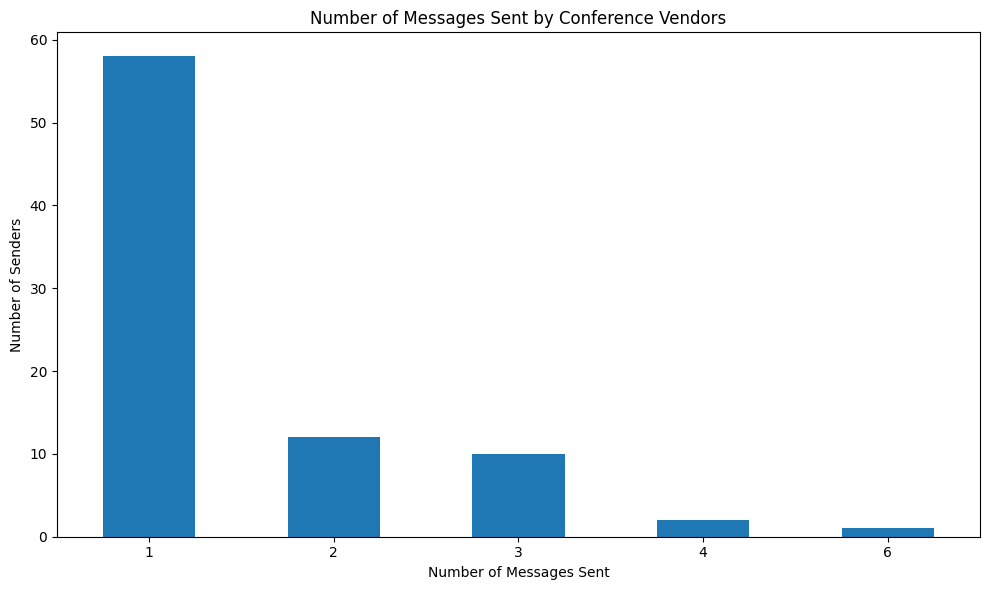

In [38]:
import matplotlib.pyplot as plt

# Group by sender and count the number of messages
sender_counts = df.groupby('sender').size()

# Group by the counts and count the number of senders for each message count
message_count_distribution = sender_counts.value_counts().sort_index()

# Plotting the counts as a bar chart
plt.figure(figsize=(10, 6))
message_count_distribution.plot(kind='bar')
plt.title('Number of Messages Sent by Conference Vendors')
plt.xlabel('Number of Messages Sent')
plt.ylabel('Number of Senders')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()


In [18]:
sender_counts.sort_values()

sender
"Agilysys Events" <connect@agilysys.com>                               1
Vincent Oliver <vince@hotelgeofencing.com>                             1
David Wood <dave.wood@datavail.com>                                    1
Elizabeth Smith <elizabeths@tripleseat.com>                            1
Evan Wimpey <evan.wimpey@elderresearch.com>                            1
                                                                      ..
"Cloud5" <marketing@cloud5.com>                                        3
Alec Galbraith <alec.galbraith@chargebackgurus.com>                    3
"Jeff Kessinger" <jeff.kessinger@jonaschorum.com>                      4
Bittel Americas <damaris.tania@bittelamericas.com>                     4
=?UTF-8?B?ZGFpbHlwb2ludOKEog==?= <BigDataHotel@news.dailypoint.com>    6
Length: 83, dtype: int64

In [20]:
def find_words_in_email(df, word, case_sensitive=False, check_subject=True, check_message=True):
    if not case_sensitive:
        word = word.lower()
    
    def contains_word(text):
        if not case_sensitive:
            text = text.lower()
        return word in text
    
    mask = pd.Series([False] * len(df))
    
    if check_subject:
        mask = mask | df['subject'].apply(lambda x: contains_word(str(x)))
    
    if check_message:
        mask = mask | df['message'].apply(lambda x: contains_word(str(x)))
    
    result_df = df[mask]
    
    print(f"Found {len(result_df)} messages")
    print(f"That's {len(result_df) / len(df):.2%} of all messages")
    return result_df



In [26]:
print("Number of emails with the word `meeting`?")
meeting = find_words_in_email(df, "meeting", check_message=True)

print("Number of emails with the word `beer`?")
beer = find_words_in_email(df, "beer", check_message=True)


Number of emails with the word `meeting`?
Found 50 messages
That's 39.68% of all messages
Number of emails with the word `beer`?
Found 3 messages
That's 2.38% of all messages


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\evan.wimpey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


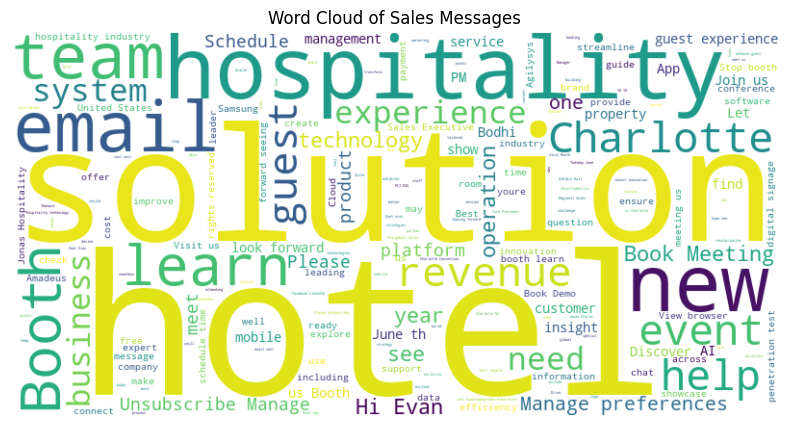

In [37]:
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords
nltk.download('stopwords')

def clean_text(text):
    if text:
        # Remove HTML tags
        soup = BeautifulSoup(text, 'lxml')
        text = soup.get_text()
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove special characters and numbers
        text = re.sub(r'[^A-Za-z\s]', '', text)
        # Remove extra spaces
        text = ' '.join(text.split())
        return text
    return ""

# Define stopwords
stop_words = set(stopwords.words('english'))

# Manually add stopwords
stop_words.add("hitec")

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

# Clean the email messages
df['clean_message'] = df['message'].apply(clean_text)
df['clean_message'] = df['clean_message'].apply(remove_stopwords)

# Concatenate all the clean email messages into a single string
all_clean_messages = ' '.join(df['clean_message'].dropna().tolist())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_clean_messages)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Sales Messages')
plt.show()


In [31]:
stop_words.update("HITEC")

In [17]:
from transformers import pipeline

# Concatenate all the clean email messages into a single string
all_clean_messages = ' '.join(df['clean_message'].dropna().tolist())



In [22]:
# Initialize the summarization pipeline
summarizer = pipeline("summarization")

summary = summarizer(all_clean_messages[:1000], max_length=1024, min_length=50, do_sample=False)

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.
Your max_length is set to 1024, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


In [23]:
summary

[{'summary_text': ' HITEC HotelGeofencingcom equips hospitality marketers with advanced locationbased advertising market help amplify reach attract hotel prospects . Learn pair geofencing streaming TV attract online bookings hotel Swing booth learn IDHotelWhiteNoTag Learn unskippable streaming TV ads . One dollar get ad shown streaming TV twenty times .'}]